In [14]:
import pandas as pd
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq
from scipy import signal as sig
from cmath import phase
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

### read shannonn df

In [2]:
path = '/storage/zkarwowska/microbiome-dynamics-preprint/datasets/alpha_diversity/'
male_shannon_df = pd.read_csv(path + '/male_shannon.csv')
female_shannon_df = pd.read_csv(path + '/female_shannon.csv', index_col = [0])

### assign date to dataframes

In [3]:
def get_date(subject):
    
    METADATA_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/raw_data/550_metadata.txt'
    metadata = pd.read_csv(METADATA_FILE, sep = '\t')
    metadata = metadata[(metadata['body_product'] == 'UBERON:feces') & \
                        (metadata['sex'] == subject) & \
                        (metadata['mislabeled']==False)].sort_values(by = 'days_since_experiment_start')

    dates = pd.date_range(start=metadata['collection_timestamp'].min(), end=metadata['collection_timestamp'].max(), freq='D')
    
    return dates

In [4]:
male_shannon_df.index = get_date('male')
female_shannon_df.index = get_date('female')

### PLOT ALPHA DIVERSITY

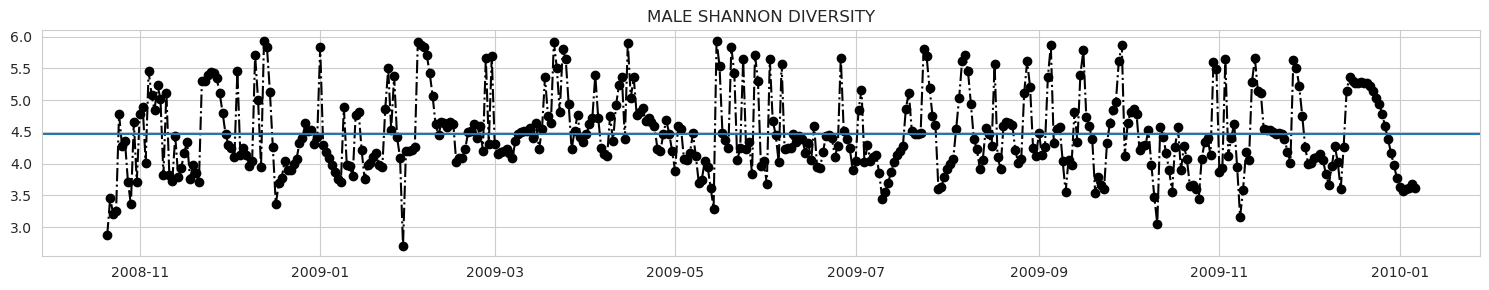

In [16]:
plt.figure(figsize = (15, 3))
plt.plot(male_shannon_df, 'ko-.')
plt.axhline(male_shannon_df.values.mean().astype(float))
plt.title('MALE SHANNON DIVERSITY')
plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/male_shannon_diversity.png')

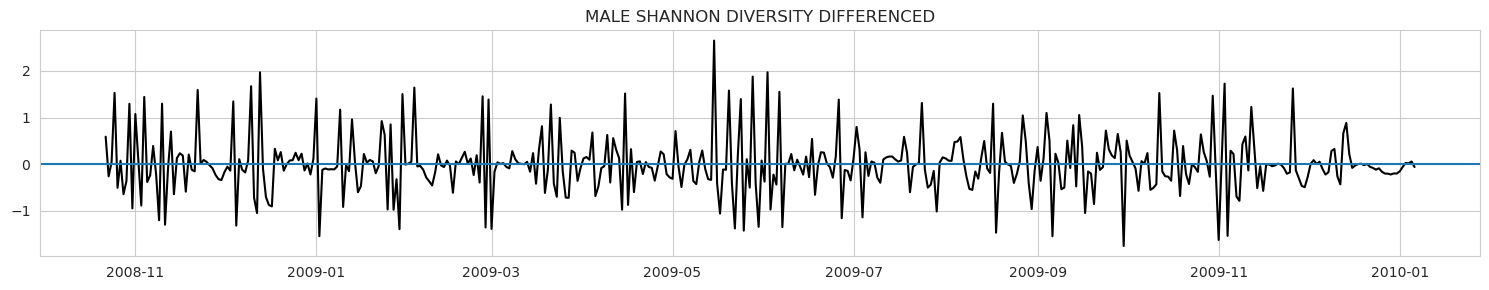

In [21]:
plt.figure(figsize = (15, 3))
plt.plot(male_shannon_df.diff().dropna(), 'k-')
plt.axhline(0)
plt.title('MALE SHANNON DIVERSITY DIFFERENCED')
plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/male_shannon_diversity_diff.png')

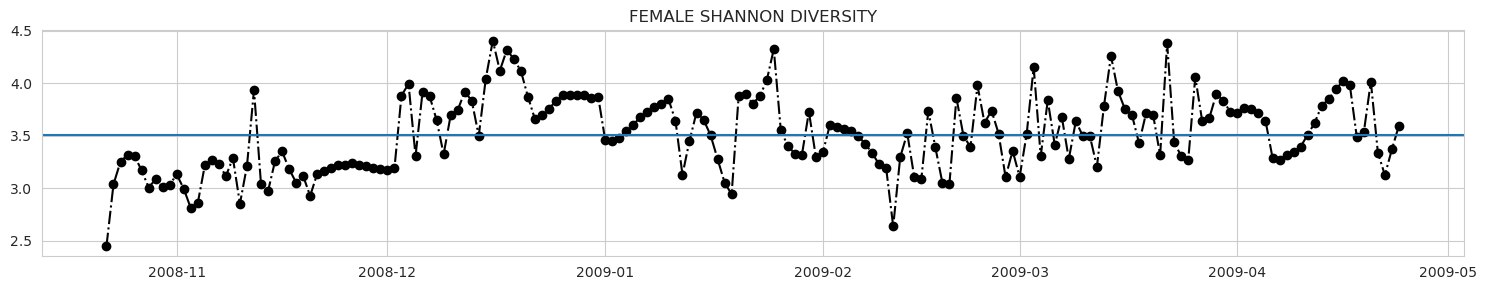

In [23]:
plt.figure(figsize = (15, 3))
plt.plot(female_shannon_df, 'ko-.')
plt.axhline(female_shannon_df.values.mean().astype(float))
plt.title('FEMALE SHANNON DIVERSITY')
plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/female_shannon_diversity.png')

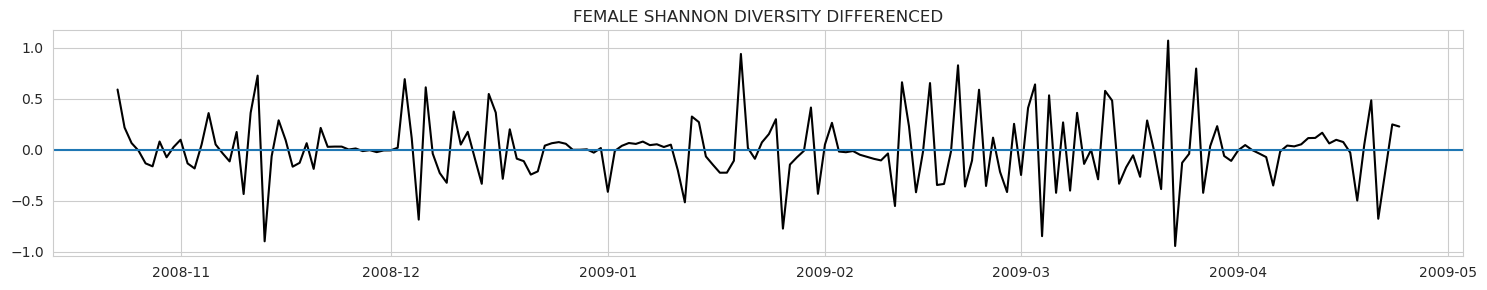

In [25]:
plt.figure(figsize = (15, 3))
plt.plot(female_shannon_df.diff().dropna(), 'k-')
plt.axhline(0)
plt.title('FEMALE SHANNON DIVERSITY DIFFERENCED')
plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/female_shannon_diversity_diff.png')

### TEST IF ALPHA DIVERSITY BEHAVES LIKE A WHITE NOISE (no autocorrelation)
https://www.kaggle.com/code/bextuychiev/how-to-detect-white-noise-and-random-walks-in-ts/notebook

#### 0. detrend

In [26]:
def detrend_series(shannon_series):
    
    data = shannon_series.copy()
    data['time'] = range(len(data))

    X = pd.DataFrame(data['time']) 
    y = pd.DataFrame(data['shannon_entropy']) 
    model = LinearRegression()
    model.fit(X, y) 

    data['pred_shannon_linreg'] = model.predict(X)
    data['residuals'] = data['shannon_entropy'] - data['pred_shannon_linreg']
    time = data['time']
    residuals = data['residuals']
    
    return residuals.values

In [27]:
female_shannon_detrended = detrend_series(female_shannon_df)
male_shannon_detrended = detrend_series(male_shannon_df)

#### 1. using acf and apcf functions

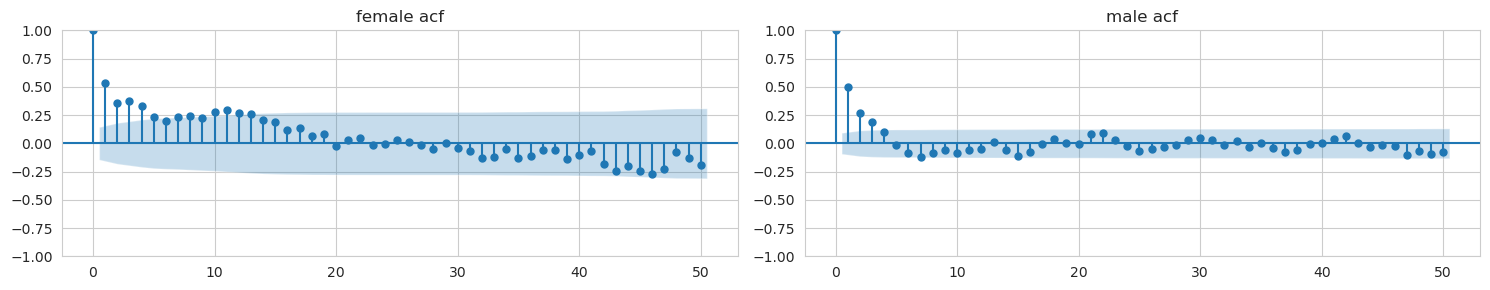

In [31]:
fig, axes = plt.subplots(1, 2, figsize = (15, 3), sharex=True)

plot_acf((female_shannon_detrended), lags=50, ax=axes[0], title='female acf')
plot_acf((male_shannon_detrended), lags=50, ax=axes[1], title='male acf')

plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/shannon_acf.png')
plt.show()

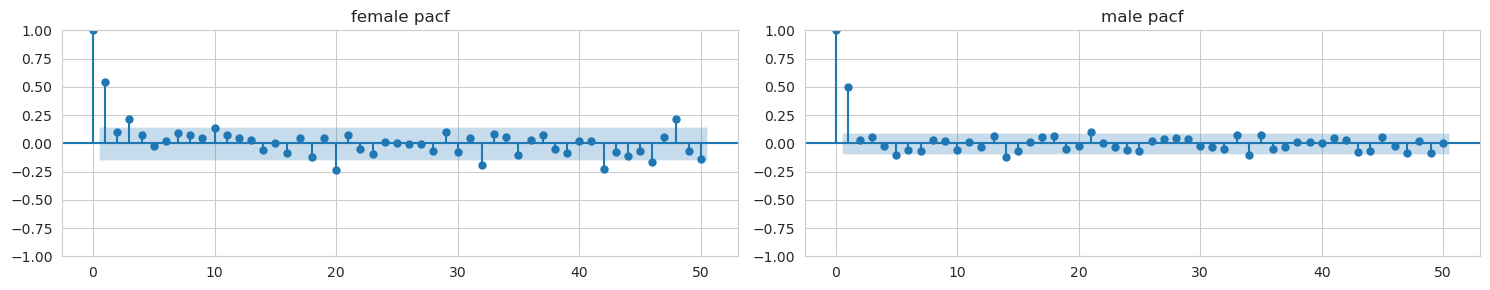

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (15, 3), sharex=True)

plot_pacf((female_shannon_detrended), lags=50, ax=axes[0], title='female pacf')
plot_pacf((male_shannon_detrended), lags=50, ax=axes[1], title='male pacf')

plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/shannon_pacf.png')
plt.show()

#### 2. using The Ljung‐Box Test for serial correlation
* H0: Null Hypothesis (White noise)
* H1: Alternative hypothesis (not white noise) there is a serial correlation

In [15]:
sm.stats.acorr_ljungbox(female_shannon_detrended, lags=[20], return_df=True) # not white noise, series has autocorrelation

,lb_stat,lb_pvalue
20,260.418367,8.989311e-44


In [16]:
sm.stats.acorr_ljungbox(male_shannon_detrended, lags=[20], return_df=True) # not white noise, series has autocorrelation

,lb_stat,lb_pvalue
20,194.115264,1.635616e-30


### TEST IF ALPHA DIVERSITY BEHAVES LIKE A RANDOM WALK (white noise despite differencing)

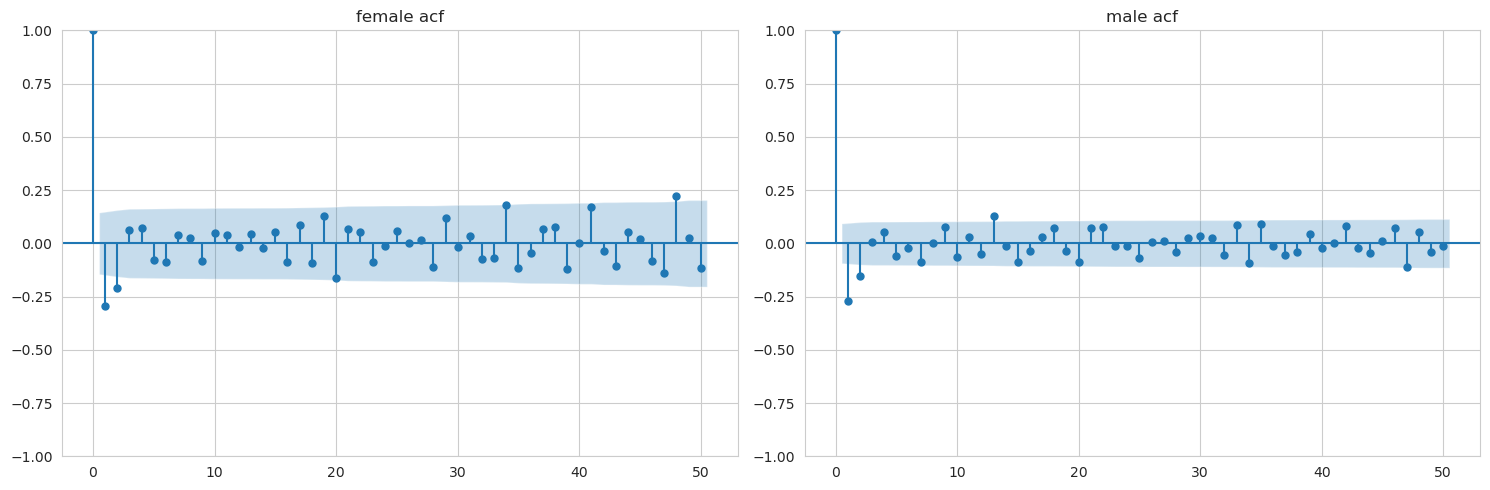

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5), sharex=True)

plot_acf(pd.DataFrame(female_shannon_detrended).diff().dropna(), lags=50, ax=axes[0], title='female acf')
plot_acf(pd.DataFrame(male_shannon_detrended).diff().dropna(), lags=50, ax=axes[1], title='male acf')

plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/shannon_white_noise.png')
plt.show()

### TEST IF ALPHA DIVERSITY IS STATIONARY

#### 1. ADF test

Calculate using ADF test if series is trend-stationary 

A time series has stationarity if a shift in time doesn’t 
cause a change in the shape of the distribution; unit roots
are one cause for non-stationarity.


    H0: series has unit root** (is not stationary)
    H1: series does not have unit root and is trend-stationary


** unit root: A unit root (also called a unit root process
or a difference stationary process) is a stochastic trend
in a time series, sometimes called a “random walk with drift”;
If a time series has a unit root, it shows a systematic pattern
that is unpredictable.

** here is pvalue > 0.05 serie is a random walk/is not stationary

In [18]:
np.round(adfuller(female_shannon_detrended, autolag="t-stat", regression='c')[1], 4) #non-stationary

0.1695

In [19]:
np.round(adfuller(female_shannon_detrended[10:], autolag="t-stat", regression='c')[1], 4) #stationary

0.0005

In [20]:
np.round(adfuller(male_shannon_detrended, autolag="t-stat", regression='c')[1], 4) #stationary

0.0

#### 2. KPSS test

* KPSS test tests if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root (random walk with drift).
    - H0: data is trend-stationary
    - H1: data is not stationary has unit root
    
* The KPSS test is based on linear regression. It breaks up a series into three parts: a deterministic trend (βt), a random walk (rt), and a stationary error (εt). If the data is stationary, it will have a fixed element for an intercept or the series will be stationary around a fixed level.

** data should be log transformed before this test to turn any exponential trends into linear ones.

** if pvalue < 0.05 then the null hypothesis is rejected; the series is non-stationary.

In [21]:
kpss(np.log(female_shannon_df.shannon_entropy.iloc[30:]))#stationary

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.11383846182599898,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [22]:
kpss(np.log(female_shannon_df.shannon_entropy.iloc[0:]))#non-stationary

(0.5569110492428725,
 0.028848862783136822,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [23]:
kpss(np.log(male_shannon_df.shannon_entropy)) #statmodels error series is stationary as the test statistic is smaller than the critical value
#https://stats.stackexchange.com/questions/518458/kpss-test-p-value-greater-than-0-05-but-test-statistic-is-less-than-critical-va

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.08834118633838775,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### ANALYSE IF SERIES HAS TREND TREND

#### Kendal Tau

In [24]:
def calculate_kendals_tau(shannon_df):
    
    var = shannon_df.values
    idx = range(len(shannon_df))

    shannon_kentals_tau, shannon_kentals_tau_pvalue = stats.kendalltau(var, idx)
    
    return shannon_kentals_tau, shannon_kentals_tau_pvalue

In [25]:
calculate_kendals_tau(female_shannon_df.iloc[30:])  #no trend

(-0.003937997486384583, 0.9420290990296694)

In [26]:
calculate_kendals_tau(male_shannon_df) #no trend

(-0.0146573649428516, 0.6448478159000581)

In [37]:
def find_trend_in_data(X, subject):
    
    data = X.copy()
    data['time'] = range(len(data))

    X = pd.DataFrame(data['time']) 
    y = pd.DataFrame(data['shannon_entropy']) 
    model = LinearRegression()
    model.fit(X, y) 

    trend = model.predict(X)
    coef = model.coef_.astype(float)
    
    plt.figure(figsize = (7, 3))
    plt.plot(data.shannon_entropy.values, 'k-.')
    plt.plot(trend, 'r:')
    plt.title('{} subject trend coeff: {}'.format(subject, coef))
    
    plt.tight_layout()
    plt.savefig('alpha_diversity_behaviour_plots/{}_trend.png'.format(subject))
    plt.show()

    plt.show()

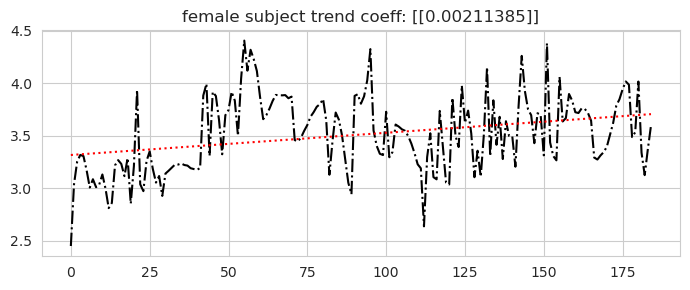

In [38]:
find_trend_in_data(female_shannon_df, 'female')

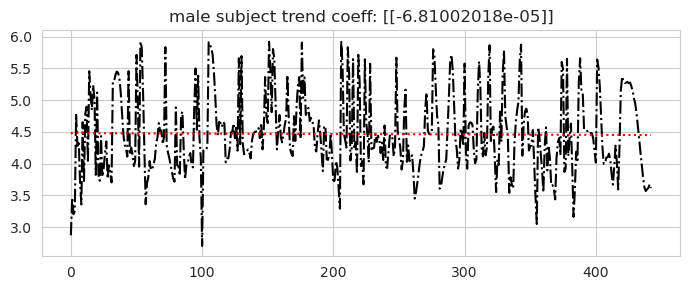

In [39]:
find_trend_in_data(male_shannon_df, 'male')

### ANALYSE SEASONALITY USING FFT

In [40]:
def analyse_seasonality_fft(shannon_df, treshold, title):
    
    fft_data = shannon_df.copy()
    fft_data['time'] = range(len(shannon_df))

    ### analyse spectrogram of the train set
    train = fft_data.copy()

    X = pd.DataFrame(train['time']) 
    y = pd.DataFrame(train['shannon_entropy']) 
    model = LinearRegression()
    model.fit(X, y) 

    train['pred_shannon_linreg'] = model.predict(X)
    train['residuals'] = train['shannon_entropy'] - train['pred_shannon_linreg']
    time = train['time']
    residuals = train['residuals']

    yf = fft(residuals.values)
    N = len(residuals.values)
    T = 1/N
    xf = fftfreq(N, T)[:N//2]
    ampl = 2.0/N * np.abs(yf[0:N//2])

    df=pd.DataFrame(list(zip(xf, ampl)), columns = ['day', 'frequency'])
    df['group'] = np.where(df['frequency'] > treshold, 1, 0)
    df['day'] = df['day'].astype(int)


    plt.figure(figsize = (10, 3))
    df = df.iloc[:100]
    sns.barplot(x=df.day, y=df.frequency, width = .4, color = 'black')
    sns.scatterplot(x=df.day, y=df.frequency, hue = df.group, palette = ['black', 'red'], s=50, edgecolor='k')
    plt.xticks(rotation = 90, fontsize = 7)
    plt.title('{} SEASONALITY'.format(title))
    
    plt.tight_layout()
    plt.savefig('alpha_diversity_behaviour_plots/{}_seasonality_fft.png'.format(title))
    plt.show()

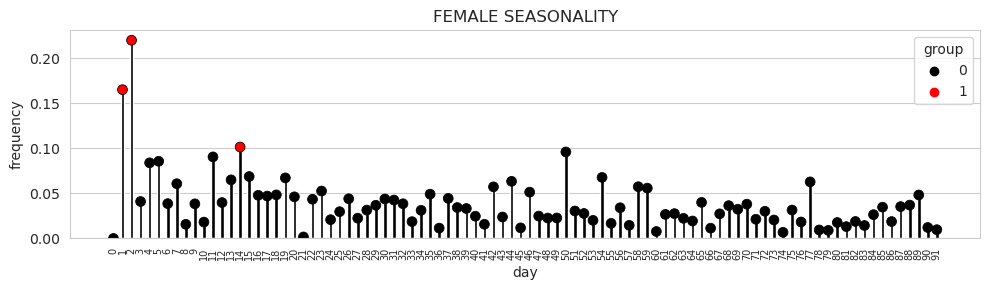

In [42]:
analyse_seasonality_fft(female_shannon_df, 0.1, 'FEMALE')

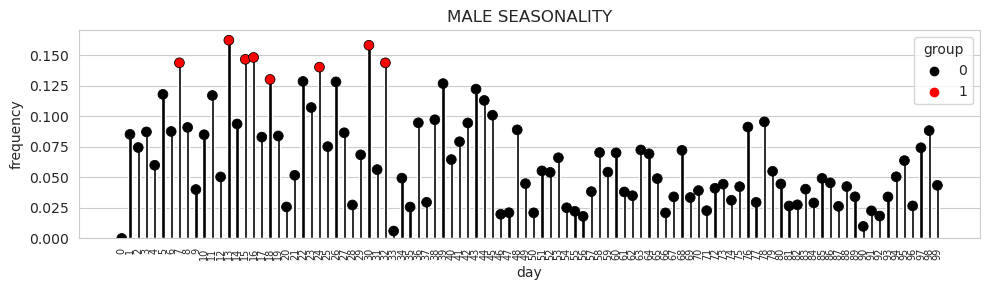

In [43]:
analyse_seasonality_fft(male_shannon_df, 0.13, 'MALE')

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


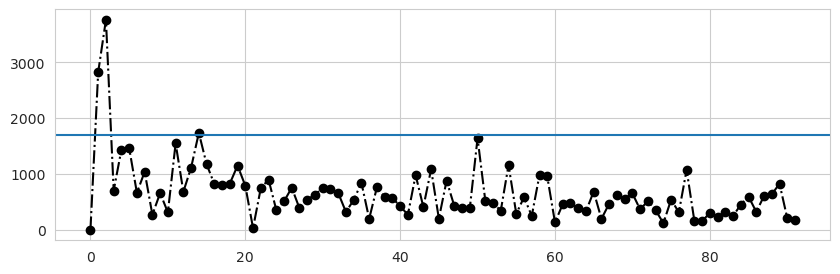

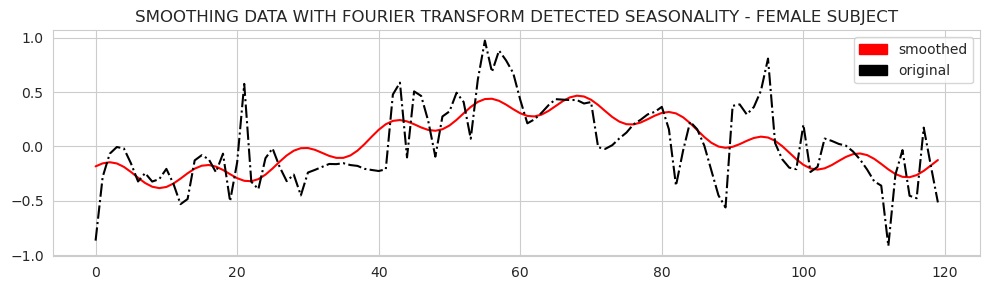

In [49]:
fft_data = female_shannon_df.copy()
fft_data['time'] = range(len(fft_data))

### analyse spectrogram of the train set
train = fft_data.copy()

X = pd.DataFrame(train['time']) 
y = pd.DataFrame(train['shannon_entropy']) 
model = LinearRegression()
model.fit(X, y) 

train['pred_shannon_linreg'] = model.predict(X)
train['residuals'] = train['shannon_entropy'] - train['pred_shannon_linreg']

time = train['time']
residuals = train['residuals']

yf = fft(residuals.values)
N = len(residuals.values)

T = 1/N
xf = fftfreq(N, T)[:N]
ampl = N * np.abs(yf[0:N])


plt.figure(figsize = (10, 3))
plt.plot(xf[:92], ampl[:92], 'ko-.') #plot to detect seasoanlity
plt.axhline(y = 1700)

_mask = ampl > 1700
masked_yf = _mask * yf

plt.figure(figsize = (10, 3))
plt.plot(ifft(masked_yf, n = N)[:120], 'r')
plt.plot(residuals.values[:120], 'k-.')

red_patch = mpatches.Patch(color='red', label='smoothed')
k_patch = mpatches.Patch(color='k', label='original')

plt.legend(handles=[red_patch, k_patch])


plt.title('SMOOTHING DATA WITH FOURIER TRANSFORM DETECTED SEASONALITY - FEMALE SUBJECT')
plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/female_seasonality_smoothing_fft.png')
plt.show()


/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


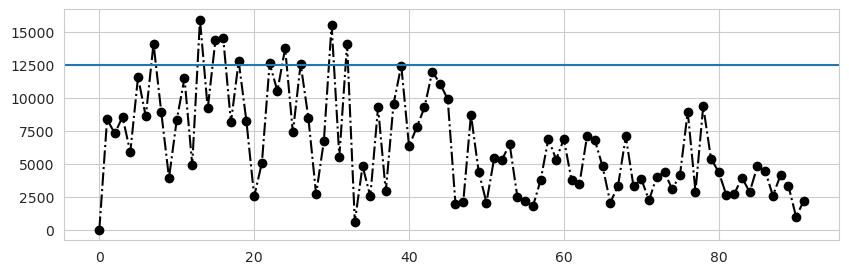

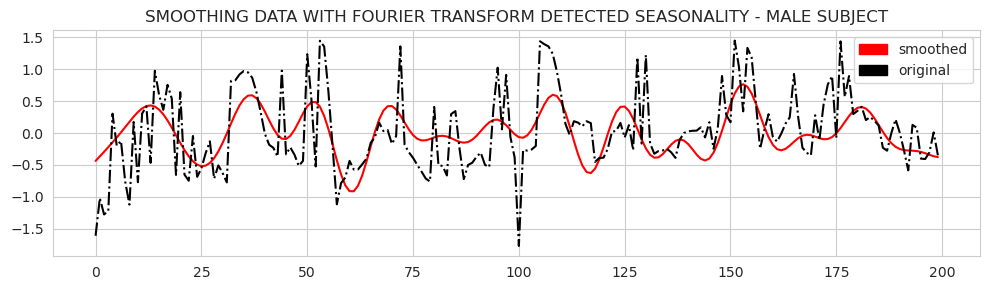

In [50]:
fft_data = male_shannon_df.copy()
fft_data['time'] = range(len(fft_data))

### analyse spectrogram of the train set
train = fft_data.copy()

X = pd.DataFrame(train['time']) 
y = pd.DataFrame(train['shannon_entropy']) 
model = LinearRegression()
model.fit(X, y) 

train['pred_shannon_linreg'] = model.predict(X)
train['residuals'] = train['shannon_entropy'] - train['pred_shannon_linreg']

time = train['time']
residuals = train['residuals']

yf = fft(residuals.values)
N = len(residuals.values)

T = 1/N
xf = fftfreq(N, T)[:N] # x
ampl = N * np.abs(yf[0:N]) #y


plt.figure(figsize = (10, 3))
plt.plot(xf[:92], ampl[:92], 'ko-.') #plot to detect seasoanlity
plt.axhline(y = 12500)

_mask = ampl > 12500
masked_yf = _mask * yf

plt.figure(figsize = (10, 3))
plt.plot(ifft(masked_yf, n = N)[:200], 'r')
plt.plot(residuals.values[:200], 'k-.')

plt.title('SMOOTHING DATA WITH FOURIER TRANSFORM DETECTED SEASONALITY - MALE SUBJECT')
red_patch = mpatches.Patch(color='red', label='smoothed')
k_patch = mpatches.Patch(color='k', label='original')

plt.legend(handles=[red_patch, k_patch])


plt.tight_layout()
plt.savefig('alpha_diversity_behaviour_plots/male_seasonality_smoothing_fft.png')
plt.show()


In [52]:
### denoise with fourier transform
def fft_denoiser(x, n_components, to_real=True):
    
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n

    # keep high frequencies
    _mask = PSD > n_components #based on PSD values
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

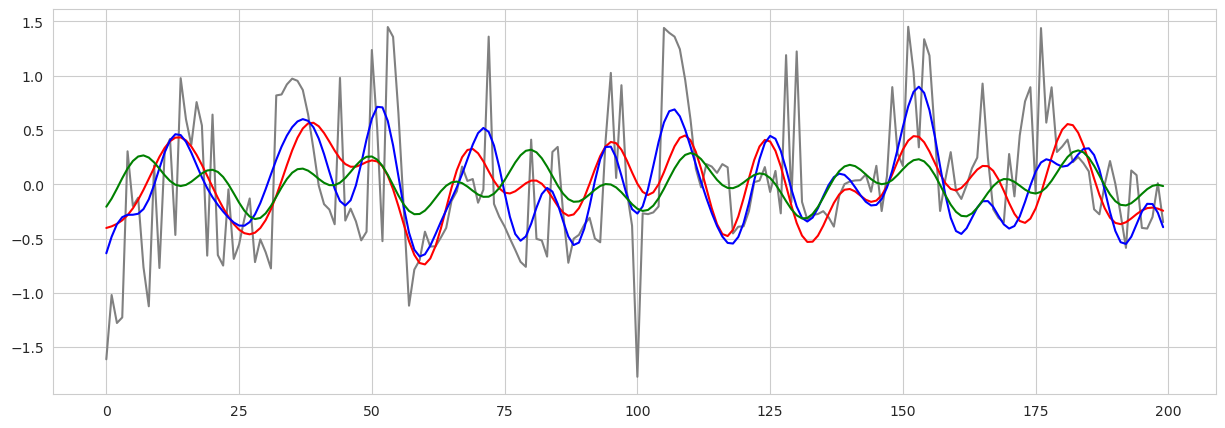

In [53]:
x = male_shannon_detrended

denoised_shannon_05 = fft_denoiser(x.reshape(len(x), ), 2)
denoised_shannon_03 = fft_denoiser(x.reshape(len(x), ), 1.5)
denoised_shannon_02 = fft_denoiser(x.reshape(len(x), ), 2.5)

plt.figure(figsize = (15, 5))
plt.plot(x[:200], 'grey')
plt.plot(denoised_shannon_05[:200], 'r')
plt.plot(denoised_shannon_03[:200], 'blue')
plt.plot(denoised_shannon_02[:200], 'green')

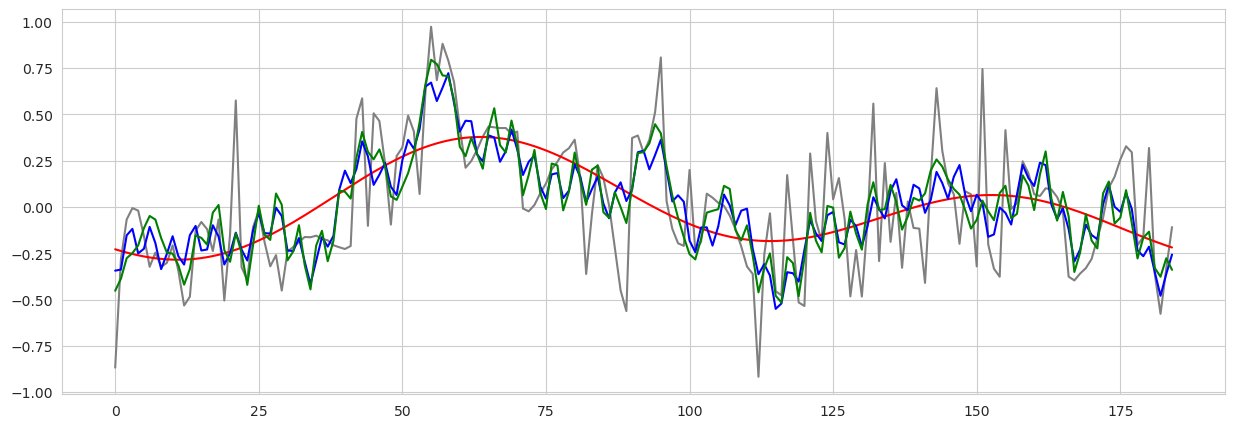

In [54]:
x = female_shannon_detrended

denoised_shannon_05 = fft_denoiser(x.reshape(len(x), ), .5)
denoised_shannon_03 = fft_denoiser(x.reshape(len(x), ), .3)
denoised_shannon_02 = fft_denoiser(x.reshape(len(x), ), .2)

plt.figure(figsize = (15, 5))
plt.plot(x, 'grey')
plt.plot(denoised_shannon_05, 'r')
plt.plot(denoised_shannon_03, 'blue')
plt.plot(denoised_shannon_02, 'green')

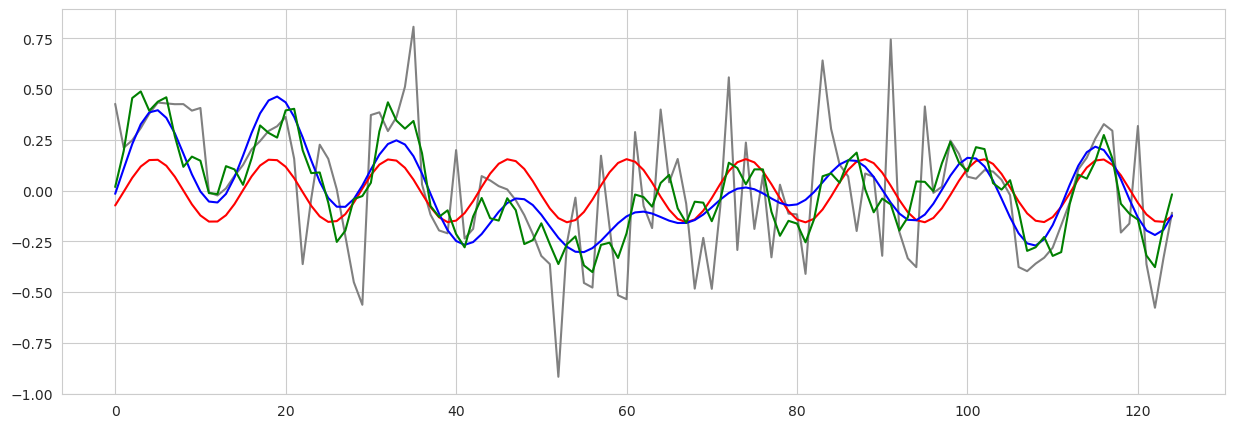

In [56]:
x = female_shannon_detrended[60:]

denoised_shannon_05 = fft_denoiser(x.reshape(len(x), ), .5)
denoised_shannon_03 = fft_denoiser(x.reshape(len(x), ), .3)
denoised_shannon_02 = fft_denoiser(x.reshape(len(x), ), .2)

plt.figure(figsize = (15, 5))
plt.plot(x, 'grey')
plt.plot(denoised_shannon_05, 'r')
plt.plot(denoised_shannon_03, 'blue')
plt.plot(denoised_shannon_02, 'green')